In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import os
from pprint import pprint
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
# from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
# Import things that are needed generically
import requests

from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool

from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_openai import ChatOpenAI

from langchain import hub
from langchain.agents import AgentExecutor, create_openai_tools_agent

import tool_pool as tp

dotenv_path = '/Users/minkyuramen/Desktop/project/env'
load_dotenv(dotenv_path)

api_key = os.getenv("SEMANTIC_SCHOLAR_API_KEY")
openai_key = os.getenv("OPENAI_API_KEY")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /Users/minkyuramen/.cache/huggingface/token
Login successful
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /Users/minkyuramen/.cache/huggingface/token
Login successful


In [2]:
# load model
model = ChatOpenAI(model="gpt-3.5-turbo")
# load tool
tools = [tp.loadpaper, tp.recommendpaper]
# load Agent prompt
prompt = hub.pull("hwchase17/openai-tools-agent")

# Choose the LLM that will drive the agent
# Only certain models support this
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Construct the OpenAI Tools agent
agent = create_openai_tools_agent(llm, tools, prompt)
# Create an agent executor by passing in the agent and tools
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [3]:
def search_arxiv(query, max_results=1):
    '''
    1. semantic scoloar에서 pid와 paper 정보 검색
    2. pid를 통해 arxiv_id 검색
    해당 논문에 대한 id, title을 return
    '''
    # Define the API endpoint URL
    url = 'https://api.semanticscholar.org/graph/v1/paper/search?fields=paperId,title,authors,publicationDate'

    # paper name 기입
    query_params = {'query': query}
    headers = {'x-api-key': api_key}

    response = requests.get(url, params=query_params, headers=headers).json()
    # print(response)
    paper_id = response['data'][0]['paperId']
    paper_title = response['data'][0]['title']
    paper_authors = [author['name'] for author in response['data'][0]['authors']]
    paper_published = response['data'][0]['publicationDate']
    print(f'### Searched Paper ###')
    print(f'Title: {paper_title}')
    print(f'Authors: {paper_authors}')
    print(f'Published: {paper_published}')
    # print(f'ID: {paper_id}')

    url = f'https://api.semanticscholar.org/graph/v1/paper/{paper_id}?fields=externalIds'
    headers = {'x-api-key': api_key}
    response = requests.get(url, params=query_params, headers=headers).json()
    print(response)
    arxiv_id = response['externalIds']['ArXiv']
    print(f'ArXiv_id: {arxiv_id}')

    return arxiv_id, paper_title

def download_pdf(arxiv_id, path_db='./papers_db'):
    """
    1. arXiv ID를 바탕으로 PDF를 path_db에 다운로드
    2. path_db에 이미 다운로드된 파일이 있다면, 다운로드를 skip
    다운로드된 파일의 path return
    """
    if not os.path.exists(path_db):
        os.makedirs(path_db)
    
    file_path = os.path.join(path_db, f'{arxiv_id}.pdf')
    
    if os.path.exists(file_path):
        print(f"File {file_path} already exists. Skipping download.")
        return file_path

    pdf_url = f'https://arxiv.org/pdf/{arxiv_id}.pdf'
    print(f'Downloading PDF from {pdf_url}')
    response = requests.get(pdf_url)

    if response.status_code != 200:
        raise Exception('Error downloading PDF from arXiv')

    with open(file_path, 'wb') as file:
        file.write(response.content)
    return file_path

In [49]:
query = 'Toolformer'
paper_id, title = search_arxiv(query)
download_path = download_pdf(paper_id)

### Searched Paper ###
Title: Toolformer: Language Models Can Teach Themselves to Use Tools
Authors: ['Timo Schick', 'Jane Dwivedi-Yu', 'Roberto Dessì', 'Roberta Raileanu', 'M. Lomeli', 'Luke Zettlemoyer', 'Nicola Cancedda', 'Thomas Scialom']
Published: 2023-02-09
{'paperId': '53d128ea815bcc0526856eb5a9c42cc977cb36a7', 'externalIds': {'DBLP': 'journals/corr/abs-2302-04761', 'ArXiv': '2302.04761', 'DOI': '10.48550/arXiv.2302.04761', 'CorpusId': 256697342}}
ArXiv_id: 2302.04761
File ./papers_db/2302.04761.pdf already exists. Skipping download.


In [50]:
# PDF 파일 경로와 출력 폴더 경로 설정
output_dir = download_path.replace('.pdf', '')
arxiv_id = output_dir.split('/')[-1]
print(arxiv_id)
print(output_dir)

2302.04761
./papers_db/2302.04761


In [51]:
import arxiv
import os
import tarfile

def download_arxiv_source(arxiv_id, output_dir):
    # 검색한 arXiv 논문 정보 가져오기
    search = arxiv.Search(id_list=[arxiv_id])
    paper = next(search.results())

    # 소스 파일 다운로드 링크
    source_url = paper.pdf_url.replace('pdf', 'e-print')
    
    # 출력 디렉토리가 없으면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 파일 다운로드
    response = requests.get(source_url)
    output_path = os.path.join(output_dir, f"{arxiv_id}.tar.gz")
    with open(output_path, 'wb') as f:
        f.write(response.content)
    
    file_path = f'{output_path}'
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=output_dir)
    
    print(f"Source files downloaded to: {output_path}")

# 함수 호출하여 소스 파일 다운로드
download_arxiv_source(arxiv_id, output_dir)

Source files downloaded to: ./papers_db/2302.04761/2302.04761.tar.gz


In [55]:
def list_pdf_files(folder_path):
    pdf_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.pdf')]
    if pdf_files == []:
        folder_path = folder_path + '/figures'
        print(folder_path)
        pdf_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.pdf')]
    return pdf_files

figure = list_pdf_files(output_dir)
figure

./papers_db/2302.04761/figures


['prompt.pdf', 'approach.pdf', 'scaling_laws.pdf', 'example.pdf']

./papers_db/2302.04761
./papers_db/2302.04761/prompt.pdf
./papers_db/2302.04761/figures/approach.pdf


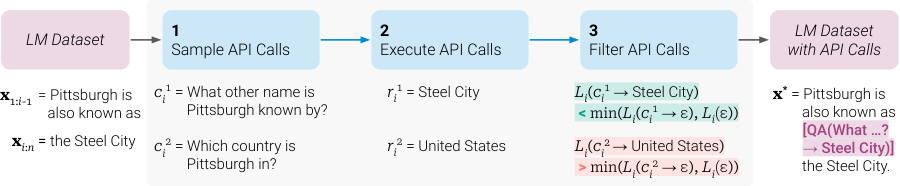

In [73]:
import fitz  # PyMuPDF
from PIL import Image
import os
import io
from IPython.display import display, Image as IPImage

def display_figure(pdf_path,figure):
    try:
        pdf_path1 = pdf_path+'/'+figure[0]
        print(pdf_path1)
        # PDF 파일 열기
        pdf_document = fitz.open(pdf_path1)
        
        # 첫 페이지 가져오기
        page = pdf_document.load_page(0)
        pix = page.get_pixmap()
        
        # 이미지 변환
        image_bytes = pix.tobytes()
        image = Image.open(io.BytesIO(image_bytes))
        name = pdf_path1.split('/')[-1].replace('.pdf', '')

    except:
        pdf_path2 = pdf_path + '/figures/'+figure[1]
        print(pdf_path2)
        # PDF 파일 열기
        pdf_document = fitz.open(pdf_path2)
        
        # 첫 페이지 가져오기
        page = pdf_document.load_page(0)
        pix = page.get_pixmap()
        
        # 이미지 변환
        image_bytes = pix.tobytes()
        image = Image.open(io.BytesIO(image_bytes))
        name = pdf_path2.split('/')[-1].replace('.pdf', '')

    return image, name
print(output_dir)
image, name = display_figure(output_dir,figure)
image

In [47]:
name

'Input_Emebeddings'